Processing steps for final calculations after the creation of service areas around Green Quiet Areas (GQA)

#### Step 1 Importing required libraries and load global variables

In [4]:
import geopandas as gpd
import numpy as np
import os
import matplotlib.pyplot as plt
from shapely.geometry import shape, LineString, mapping
from shapely.ops import unary_union, polygonize

In [5]:
# Path to file geodatabase directory
outPath = r'S:\Common workspace\ETC_DI\AP23_GreenQuietAreas\UrbanQuiet\Output'
gdb_path = os.path.join(outPath, 'SA_output_v3.gdb') 

# Path to data folders
indata_f = r'S:\Common workspace\ETC_DI\AP23_GreenQuietAreas\UrbanQuiet\Input'
outdata_f = r'S:\Common workspace\ETC_DI\AP23_GreenQuietAreas\UrbanQuiet\Output'

#### Step 2: Dissolve service areas (SA) by GQA identifier 

In [6]:
 # Read all layers from the geodatabase
group_id = str(230)
ID_GROUP = "GROUP_" + group_id
SA = gpd.read_file(gdb_path, driver='FileGDB', layer=f"{ID_GROUP}_sa")

path = os.path.join(outPath, 'GUA_pt_ALL_GQA_FID.shp')  
pts_GQA_FID = gpd.read_file(path)

# select a subset of columns
pts_GQA_FID = pts_GQA_FID[['FID_GQA', 'country', 'fua_name','fua_code',
'HDENS_2011', 'code_2018', 'class_2018', 'noisy',
'area_m2', 'area_ha', 'area_km2']]

# Add green area information to the SA feature
SA_FID = SA.merge(pts_GQA_FID, left_index= True, right_index= True, how= 'left')

# Dissolve by GQA identifier
SA_FID_dis = SA_FID.dissolve('FID_GQA')
SA_FID_dis.reset_index(inplace=True)

# Save temporary file
file_path = os.path.join(outdata_f, 'SA_FID_dis.shp')
SA_FID_dis.to_file(file_path, driver='ESRI Shapefile')

Q:\UserTemp\ubach\AppData\Local\Temp\11\ipykernel_64008\2941010059.py:23: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  SA_FID_dis.to_file(file_path, driver='ESRI Shapefile')


#### Step 3: Erase those areas of SA overlaping the GreenUrban Areas

In [35]:
# Load QGA
path = os.path.join(outPath, 'GQA.shp')  
GQA = gpd.read_file(path)

# Remove QGA delineation from the SA
SA_final = gpd.overlay(SA_FID_dis, GQA, how='difference')

# Save temporary file
file_path = os.path.join(outdata_f, 'SA_final.shp')
SA_final.to_file(file_path, driver='ESRI Shapefile')

Q:\UserTemp\ubach\AppData\Local\Temp\11\ipykernel_64008\929151681.py:10: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  SA_final.to_file(file_path, driver='ESRI Shapefile')


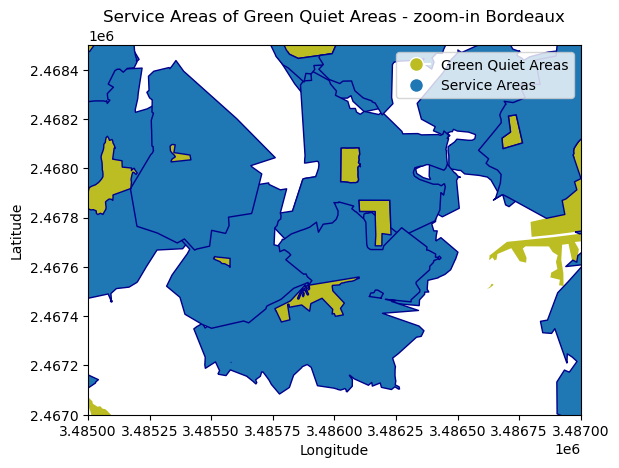

In [36]:
# Plot GQA
colors_ls = ['tab:olive', 'tab:blue']
ax = GQA.plot(facecolor=colors_ls[0], edgecolor='None', legend=True)

# Plot SAs
SA_final.plot(ax=ax, facecolor=colors_ls[1], edgecolor='darkblue', legend=True)

# Set the limits to zoom in on a specified region
ax.set_ylim(2467000, 2468500)
ax.set_xlim(3485000, 3487000)

# Set plot labels and title
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Service Areas of Green Quiet Areas - zoom-in Bordeaux')

# Show the legend with customized labels
legend_labels = {'Green Quiet Areas': 'Green Quiet Areas', 'Service Areas': 'Service Areas'}
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in colors_ls]
ax.legend(handles=handles, labels=legend_labels.values())

# Display the plot
plt.show()

#### Step 4: Calculate the portion of SA that intersect between each other (SA_final)

Some polygons from the service areas are intersecting with other service areas generated from different GQAs. This meaning some polygons overlap where different service areas coincide. To properly assign the amount of qreen quiet area with accessibility, we need to differentiate these areas and sum the number of areas from the different GQA that serves.

In [37]:
# select a subset of columns
SA_final = SA_final[['FID_GQA',
 'area_m2',
 'area_ha',
 'geometry']]

In [38]:
## Creating non-overlapping units following the proposed approach from:
## https://gis.stackexchange.com/questions/187402/how-to-find-the-intersection-areas-of-overlapping-buffer-zones-in-single-shapefi/187499#187499

# Split multipart polygons to single part polygons
SA_FID_mp = SA_final.explode(ignore_index=True)

# create unique features from input polygons
rings = [LineString(list(shape(geometry).exterior.coords)) for geometry in SA_FID_mp['geometry']]
union = unary_union(rings)
SA_no_overlaps = [geom for geom in polygonize(union)]

# Create a new GeoDataFrame for the result
SA_no_overlaps_gdf = gpd.GeoDataFrame(geometry=SA_no_overlaps)

# Add an 'area' column to the new GeoDataFrame
SA_no_overlaps_gdf['area'] = SA_no_overlaps_gdf['geometry'].area
SA_no_overlaps_gdf.crs = SA_FID_mp.crs

# remove again the GQA
SA_no_overlaps_gdf = gpd.overlay(SA_no_overlaps_gdf, GQA, how='difference')

# Add unique id field
SA_no_overlaps_gdf['unique_id'] = range(len(SA_no_overlaps_gdf))

# Save the result GeoDataFrame to shapefile
file_path = os.path.join(outdata_f, 'SA_no_overlaps.shp')
SA_no_overlaps_gdf.to_file(file_path, driver='ESRI Shapefile')

Q:\UserTemp\ubach\AppData\Local\Temp\11\ipykernel_64008\208558994.py:20: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  SA_no_overlaps_gdf = gpd.overlay(SA_no_overlaps_gdf, GQA, how='difference')


In [39]:
result_erase_FIDs_left = gpd.sjoin(SA_no_overlaps_gdf, SA_final, how= 'left', op='intersects')
SA_GQA_total = result_erase_FIDs_left.dissolve(by='unique_id', aggfunc={'area_m2': 'sum', 'FID_GQA': ['count', 'first']})
SA_GQA_total.reset_index(inplace=True)
SA_GQA_total.columns = ['unique_id', 'geometry', 'total_area_m2', 'FID_GQA_count', 'FID_GQA_first']

c:\Users\ubach\.conda\envs\geospatial_ETC_DI_v4\lib\site-packages\IPython\core\interactiveshell.py:3382: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [40]:
SA_GQA_total

,unique_id,geometry,total_area_m2,FID_GQA_count,FID_GQA_first
0,0,"POLYGON ((3485217.304 2475183.692, 3485252.234...",178770.002306,4,327
1,1,"POLYGON ((3485365.031 2474998.691, 3485383.825...",16265.322519,2,341
2,2,"POLYGON ((3485302.448 2474814.608, 3485311.259...",120007.896623,5,337
3,3,"POLYGON ((3484916.041 2474668.708, 3484904.215...",8126.677858,2,327
4,4,"POLYGON ((3484966.869 2474849.688, 3484952.669...",167987.200262,3,327
...,...,...,...,...,...
3333,3333,"POLYGON ((3486715.194 2474454.977, 3486676.845...",106263.749138,5,435
3334,3334,"POLYGON ((3486929.266 2474098.952, 3486931.607...",45479.516207,5,22
3335,3335,"POLYGON ((3482007.665 2471991.615, 3482010.723...",1696.530171,1,434
3336,3336,"POLYGON ((3486679.045 2473691.123, 3486679.114...",35007.298213,3,22


In [41]:
# Remove the outer areas from urban centers
# Load urban center delineation
path = os.path.join(indata_f, 'HDC2021_RG.shp')  
urban_center = gpd.read_file(path)
urban_center = urban_center.query('HDENS_NAME =="Bordeaux"')

# Remove QGA delineation from the SA
SA_GQA_urbc = gpd.overlay(SA_GQA_total, urban_center, how='intersection')
file_path = os.path.join(outdata_f, 'SA_GQA_urbc.shp')
SA_GQA_urbc.to_file(file_path, driver='ESRI Shapefile')

Q:\UserTemp\ubach\AppData\Local\Temp\11\ipykernel_64008\3705143651.py:7: UserWarning: `keep_geom_type=True` in overlay resulted in 83 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  SA_GQA_urbc = gpd.overlay(SA_GQA_total, urban_center, how='intersection')
Q:\UserTemp\ubach\AppData\Local\Temp\11\ipykernel_64008\3705143651.py:9: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  SA_GQA_urbc.to_file(file_path, driver='ESRI Shapefile')


#### Step 5: Final computations including population

Compute Total Green Areas

In [146]:
# Read Urban Atlas data
data_f = r'A:\Copernicus\UrbanAtlas\UrbanAtlas\UA2018'
file_path = os.path.join(data_f, r'FR007L2_BORDEAUX_UA2018_v013\Data\FR007L2_BORDEAUX_UA2018_v013.gpkg')

# Read the GeoPackage file
ua = gpd.read_file(file_path, layer='FR007L2_BORDEAUX_UA2018')

In [152]:
# Read shapefile
data_f = r'S:\Common workspace\ETC_DI\AP23_GreenQuietAreas\UrbanQuiet\Input'
file_path = os.path.join(data_f, 'HDC2021_RG.shp')

# Read the GeoPackage file
uc = gpd.read_file(file_path)

# Urban center for Bordeaux
uc_bdx = uc.query('HDENS_NAME == "Bordeaux"')

In [154]:
# urban green in all FUA
uagreen = ua.query('code_2018 == "14100" or code_2018 == "31000"')
# urban green within the Urban Center
uagreen_urbc = gpd.overlay(uagreen, uc_bdx, how='intersection')

In [148]:
ua.area.sum()*0.0001

555595.7914096091

In [145]:
uagreen.area.sum()*0.0001

275402.4806754545

In [155]:
uagreen_urbc.area.sum()*0.0001

1938.046991322812

In [150]:
GQA.area.sum()*0.0001

1105.4458778726878

In [66]:
uagreen_urbc.head()

,country,fua_name,fua_code,code_2018,class_2018,prod_date,identifier,perimeter,area,comment,...,FID_GQA_first,HDENS_CLST,HDENS_NAME,HDENS_2011,POPL_2021,CNTR_CODE,MBRS_CODE_,SHAPE_AREA,SHAPE_LEN,geometry
0,FR,Bordeaux,FR007L2,14100,Green urban areas,2020-01,41439-FR007L2,324.792007,5752.133073,None,...,327,GEOSTAT21_595,Bordeaux,GEOSTAT11_595,690408.0,FR,1,183000000.0,88000.0,"POLYGON ((3484981.105 2474871.035, 3484980.735..."
1,FR,Bordeaux,FR007L2,14100,Green urban areas,2020-01,41439-FR007L2,324.792007,5752.133073,None,...,327,GEOSTAT21_595,Bordeaux,GEOSTAT11_595,690408.0,FR,1,183000000.0,88000.0,"POLYGON ((3484977.002 2474874.618, 3484981.950..."
2,FR,Bordeaux,FR007L2,14100,Green urban areas,2020-01,41548-FR007L2,2869.748431,247101.268040,None,...,327,GEOSTAT21_595,Bordeaux,GEOSTAT11_595,690408.0,FR,1,183000000.0,88000.0,"POLYGON ((3484814.812 2475172.268, 3484814.790..."
3,FR,Bordeaux,FR007L2,14100,Green urban areas,2020-01,41090-FR007L2,167.670852,1843.689929,None,...,81,GEOSTAT21_595,Bordeaux,GEOSTAT11_595,690408.0,FR,1,183000000.0,88000.0,"POLYGON ((3484821.752 2468129.080, 3484821.678..."
4,FR,Bordeaux,FR007L2,14100,Green urban areas,2020-01,41102-FR007L2,482.098104,5404.861439,None,...,81,GEOSTAT21_595,Bordeaux,GEOSTAT11_595,690408.0,FR,1,183000000.0,88000.0,"POLYGON ((3484808.507 2468197.513, 3484815.016..."


In [157]:
# All green areas (GUAs and forests) in the urban center (including data outside the ncm)
TotalGreenArea = uagreen_urbc.geometry.area.sum()
TotalGreenAreaHa = TotalGreenArea/10000

Green areas excluded (areas not covered by ncm)

In [160]:
# Load the delineation for the agglomeration
# Read noise data
file_path = os.path.join(indata_f, 'NoiseData\Agglomerations-StrategicNoiseMaps-multipoly.gpkg')
# Read the GeoPackage file
ncm = gpd.read_file(file_path, layer='NoiseContours_roadsInAgglomeration_Lden')

# Read agglomerations delineations
file_path = os.path.join(indata_f, 'NoiseData\DF15_latestDelivery_POLARBEAR_230724.gpkg')
agls = gpd.read_file(file_path, layer = 'dbo.DF15_AgglomerationSource_Valid_LatestDelivery')

# select Bordeaux
agl_BDX = agls.query('agglomerationName_localName == "Bordeaux"')

# Select green areas within the noise contour maps covered by noise data
uagreen_urbc_BDX = gpd.overlay(uagreen_urbc, agl_BDX, how='intersection')

In [161]:
# Excluded areas = TotalGreen in the urban center - TotalGreen in the uc & ncm 
TotalGreen_urbc_ncm = uagreen_urbc_BDX.area.sum()
green_excluded = TotalGreenArea - TotalGreen_urbc_ncm

In [188]:
TotalGreenArea/10000

1938.0469913228117

In [186]:
TotalGreen_urbc_ncm

19291870.893650003

Percentage of Green Quiet Areas

In [162]:
## Compute as:
## % of green quiet areas =  TotalGQA/(TotalGreenAreas-Green excluded) * 100
TotalGQA_m2 = GQA.area_m2.sum()

In [163]:
5.878832e+06+5.175627e+06

11054459.0

In [164]:
TotalGQA_m2

11054458.778726878

In [165]:
GQA.columns

Index(['country', 'fua_name', 'fua_code', 'HDENS_2011', 'code_2018',
       'class_2018', 'noisy', 'area_m2', 'area_ha', 'area_km2', 'geometry'],
      dtype='object')

In [166]:
TotalGreenArea

19380469.913228117

In [167]:
ua_urbc = gpd.overlay(ua, urban_center, how='intersection')

In [168]:
TotalPop = ua_urbc.Pop2018.sum()

In [169]:
ua= ua[['area','code_2018', 'Pop2018', 'geometry']].query('Pop2018>0')

In [170]:
ua['original_area_m2'] = round(ua.geometry.area,2)

In [171]:
ua

,area,code_2018,Pop2018,geometry,original_area_m2
0,6924.354692,11210,49,"MULTIPOLYGON (((3488006.429 2468985.638, 34880...",6924.35
1,5142.000564,11100,2,"MULTIPOLYGON (((3446442.890 2470711.718, 34464...",5142.00
2,3982.575676,11220,14,"MULTIPOLYGON (((3503605.413 2445087.190, 35036...",3982.58
3,4617.098115,11220,11,"MULTIPOLYGON (((3467543.865 2449883.544, 34675...",4617.10
4,3389.507534,11220,6,"MULTIPOLYGON (((3488582.743 2463459.866, 34885...",3389.51
...,...,...,...,...,...
69416,22462.809102,23000,9,"MULTIPOLYGON (((3497140.160 2494000.000, 34971...",22462.81
69417,12689.972692,23000,10,"MULTIPOLYGON (((3500533.866 2489220.226, 35005...",12689.97
69419,20909.008640,23000,1,"MULTIPOLYGON (((3482000.000 2497056.498, 34819...",20909.01
69421,37183.835180,23000,3,"MULTIPOLYGON (((3501000.000 2471810.518, 35010...",37183.84


In [172]:
# Remove QGA delineation from the SA
SA_GQA_ua = gpd.overlay(SA_GQA_urbc,ua, how='intersection')
#file_path = os.path.join(outdata_f, 'SA_GQA_urbc.shp')
#SA_GQA_urbc.to_file(file_path, driver='ESRI Shapefile')

Q:\UserTemp\ubach\AppData\Local\Temp\11\ipykernel_64008\936395552.py:2: UserWarning: `keep_geom_type=True` in overlay resulted in 45 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  SA_GQA_ua = gpd.overlay(SA_GQA_urbc,ua, how='intersection')


In [173]:
SA_GQA_ua

,unique_id,total_area_m2,FID_GQA_count,FID_GQA_first,HDENS_CLST,HDENS_NAME,HDENS_2011,POPL_2021,CNTR_CODE,MBRS_CODE_,SHAPE_AREA,SHAPE_LEN,area,code_2018,Pop2018,original_area_m2,geometry
0,0,178770.002306,4,327,GEOSTAT21_595,Bordeaux,GEOSTAT11_595,690408.0,FR,1,183000000.0,88000.0,13731.057897,11100,205,13731.06,"POLYGON ((3485289.956 2475183.401, 3485289.466..."
1,2,120007.896623,5,337,GEOSTAT21_595,Bordeaux,GEOSTAT11_595,690408.0,FR,1,183000000.0,88000.0,13731.057897,11100,205,13731.06,"POLYGON ((3485454.274 2475026.025, 3485461.633..."
2,0,178770.002306,4,327,GEOSTAT21_595,Bordeaux,GEOSTAT11_595,690408.0,FR,1,183000000.0,88000.0,5847.677548,11100,97,5847.68,"POLYGON ((3485084.487 2474907.005, 3485084.447..."
3,0,178770.002306,4,327,GEOSTAT21_595,Bordeaux,GEOSTAT11_595,690408.0,FR,1,183000000.0,88000.0,17427.450350,11100,334,17427.45,"POLYGON ((3485217.957 2474815.535, 3485169.129..."
4,1,16265.322519,2,341,GEOSTAT21_595,Bordeaux,GEOSTAT11_595,690408.0,FR,1,183000000.0,88000.0,17427.450350,11100,334,17427.45,"POLYGON ((3485216.513 2474824.305, 3485222.556..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12104,3335,1696.530171,1,434,GEOSTAT21_595,Bordeaux,GEOSTAT11_595,690408.0,FR,1,183000000.0,88000.0,1512.786242,11100,14,1512.79,"POLYGON ((3482188.559 2471981.834, 3482170.351..."
12105,3335,1696.530171,1,434,GEOSTAT21_595,Bordeaux,GEOSTAT11_595,690408.0,FR,1,183000000.0,88000.0,4612.121016,11100,21,4612.12,"POLYGON ((3482336.518 2471996.949, 3482336.514..."
12106,3335,1696.530171,1,434,GEOSTAT21_595,Bordeaux,GEOSTAT11_595,690408.0,FR,1,183000000.0,88000.0,24852.337739,11210,105,24852.34,"MULTIPOLYGON (((3482153.713 2471812.425, 34821..."
12107,3335,1696.530171,1,434,GEOSTAT21_595,Bordeaux,GEOSTAT11_595,690408.0,FR,1,183000000.0,88000.0,26662.307205,11210,124,26662.31,"POLYGON ((3482272.516 2471680.360, 3482190.058..."


In [175]:
SA_GQA_ua = SA_GQA_ua[['unique_id', 'total_area_m2','code_2018',  'Pop2018','original_area_m2',  'geometry']]

In [ ]:
SA_GQA_ua['final_area_m2'] = round(SA_GQA_ua.geometry.area,2)
SA_GQA_ua['area_prop'] = SA_GQA_ua['final_area_m2']/SA_GQA_ua['original_area_m2']
SA_GQA_ua['Pop2018_poly'] = SA_GQA_ua['Pop2018']*SA_GQA_ua['area_prop']
SA_GQA_ua['Pop2018_final'] = round(SA_GQA_ua.Pop2018_poly,0)

In [177]:
SA_GQA_ua.head()

,unique_id,total_area_m2,code_2018,Pop2018,original_area_m2,geometry,final_area_m2,area_prop,Pop2018_poly,Pop2018_final
0,0,178770.002306,11100,205,13731.06,"POLYGON ((3485289.956 2475183.401, 3485289.466...",1079.71,0.078633,16.119699,16.0
1,2,120007.896623,11100,205,13731.06,"POLYGON ((3485454.274 2475026.025, 3485461.633...",1459.88,0.106320,21.795506,22.0
2,0,178770.002306,11100,97,5847.68,"POLYGON ((3485084.487 2474907.005, 3485084.447...",5847.68,1.000000,97.000000,97.0
3,0,178770.002306,11100,334,17427.45,"POLYGON ((3485217.957 2474815.535, 3485169.129...",17403.49,0.998625,333.540803,334.0
4,1,16265.322519,11100,334,17427.45,"POLYGON ((3485216.513 2474824.305, 3485222.556...",23.96,0.001375,0.459197,0.0


In [178]:
# compute the weighted median for the area
column_to_compute_median = 'total_area_m2'

# Compute the weighted median
weighted_median = np.average(SA_GQA_ua[column_to_compute_median], weights=SA_GQA_ua['Pop2018_poly'])

In [179]:
GQA.head()

,country,fua_name,fua_code,HDENS_2011,code_2018,class_2018,noisy,area_m2,area_ha,area_km2,geometry
0,FR,Bordeaux,FR007L2,GEOSTAT11_595,14100,Green urban areas,0,5482.520475,0.55,0.01,"POLYGON ((3484952.812 2474926.929, 3484978.426..."
1,FR,Bordeaux,FR007L2,GEOSTAT11_595,14100,Green urban areas,0,9437.546036,0.94,0.01,"POLYGON ((3485253.561 2476326.538, 3485293.775..."
2,FR,Bordeaux,FR007L2,GEOSTAT11_595,14100,Green urban areas,0,3340.957782,0.33,0.00,"POLYGON ((3482568.094 2469317.124, 3482588.419..."
3,FR,Bordeaux,FR007L2,GEOSTAT11_595,14100,Green urban areas,0,5018.856511,0.50,0.00,"POLYGON ((3485988.105 2474998.814, 3485934.404..."
4,FR,Bordeaux,FR007L2,GEOSTAT11_595,14100,Green urban areas,0,2946.033960,0.29,0.00,"POLYGON ((3486150.554 2475185.315, 3486152.530..."


Compute Percentage of Green Quiet Areas

In [180]:
## Compute as:
## % of green quiet areas =  TotalGQA/(TotalGreenAreas-Green excluded) * 100
TotalGQA_m2 = GQA.area_m2.sum()


Capturing variables to build final tables 

In [190]:
# Create lists to capture output variables
HDENS_NAME_ls = []
HDENS_2011_ls = []
CNTR_CODE_ls = []
POPL_2021_ls = []

In [192]:
UrbanCenterName = urban_center.HDENS_NAME.unique()[0]
UrbanCenterCode = urban_center.HDENS_2011.unique()[0]
UrbanCenterCountry = urban_center.CNTR_CODE.unique()[0]
UrbanCenterPOP21 = urban_center.POPL_2021.unique()[0]

In [193]:
HDENS_NAME_ls.append(UrbanCenterName)
HDENS_2011_ls.append(UrbanCenterCode)
CNTR_CODE_ls.append(UrbanCenterCountry)
POPL_2021_ls.append(UrbanCenterPOP21)

In [200]:
# import noiseqg from the previous notebook
%store -r nqgreen_area
nqgreen_area

,code_2018,noisy,area_m2,area_ha,area_km2
0,14100,0,5.878832e+06,587.88,5.88
1,14100,1,5.398097e+06,539.81,5.40
2,31000,0,5.175627e+06,517.56,5.18
3,31000,1,2.839315e+06,283.93,2.84


In [208]:
TotalGreenQuietArea_ha = nqgreen_area.query('noisy==0').area_ha.sum()
PercGreenQuietArea = round((TotalGreenQuietArea_ha/nqgreen_area.area_ha.sum())*100,2)


Final print

In [212]:
# Compute total people with access to GQA 
print (f'Urban Center: {UrbanCenterName} ({UrbanCenterCode}) in {UrbanCenterCountry}')
#print (f'Urban Center Code: {UrbanCenterCode}')
print(f'The number of people with access to GQA is: {int(SA_GQA_ua.Pop2018_final.sum())} people')
print(f'Total population in the urban center: {int(UrbanCenterPOP21)} people')
print(f'The Percentage of population with access to GQA is: {int(round((SA_GQA_ua.Pop2018_final.sum()/TotalPop)*100,0))}%')
print(f'Total green area in the urban center is: {round(TotalGreenArea/10000,2)} ha')
print(f'Total green area excluded “no data”: {round(green_excluded/10000,2)} ha')
print(f'Total quiet green area is: {TotalGreenQuietArea_ha} ha')
print(f'The Percentage of quiet green area is: {PercGreenQuietArea}%')
print(f'The Weighted Median of green quiet accessible area is: {round(weighted_median,2)} in m2, that is {round(weighted_median/10000,2)} ha')

Urban Center: Bordeaux (GEOSTAT11_595) in FR
The number of people with access to GQA is: 301394 people
Total population in the urban center: 690408 people
The Percentage of population with access to GQA is: 46%
Total green area in the urban center is: 1938.05 ha
Total green area excluded “no data”: 8.86 ha
Total quiet green area is: 1105.44 ha
The Percentage of quiet green area is: 57.3%
The Weighted Median of green quiet accessible area is: 97789.19 in m2, that is 9.78 ha
